# <center> CSE 4/546: Reinforcement Learning
## Assignment 3 - Actor-Critic
### Part - 3: Solving Complex Environments (Acrobot & BipedalWalker)

<b>Submitted By:</b><br>
Name - Shivansh Gupta<br>
UBIT No - 50604127<br>
UBIT Name - sgupta67<br>
UB Email ID - sgupta67@buffalo.edu<br>

Name - Karan Ramchandani<br>
UBIT No - 50610533<br>
UBIT Name - karamchan<br>
UB Email ID - karamchan@buffalo.edu<br>

#### Importing Required Libraries

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import threading
import pickle
import numpy as np
from torch.distributions import Categorical
from multiprocessing import Manager

### 1) Gym `Acrobot-v1`

#### Creating the required Neural Network for the A2C Model

In [59]:
# Creating an A2C Neural Network for the forward pass
class Acrobot_A2C_Network(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim):
        super().__init__()
        # Creating a shared layer for both actor and critic
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
        )
        # Actor output head
        self.actor  = nn.Linear(hidden_dim, act_dim)
        self.critic = nn.Linear(hidden_dim, 1)

    # Performing the forward pass
    def forward(self, x):
        out = self.shared(x)
        return self.actor(out), self.critic(out)

#### Creating additional class like Shared adam to help the model take action in a more optimized way

In [45]:
# Created a function to return the initial observation in torch format of the environment whenever called
def reset_env(env, device):
    env_reset = env.reset()
    # Checking if the state is a tuple 
    if isinstance(env_reset, tuple):
        observation = env_reset[0] 
    else:
        observation = env_reset
    observation = np.array(observation, dtype=np.float32)
    
    # Converting it to tensor
    observation_t = torch.from_numpy(observation).to(device)
    return observation_t

# Created a function to return the action in torch format, reward and done for the environment whenever called
def step_env(env, action, device):
    env_step = env.step(action)
    if len(env_step) == 5:
        next_state, reward, terminated, truncated, _ = env_step
        done = terminated or truncated
    else:
        next_state, reward, terminated, truncated, _ = env_step
        done = terminated or truncated
    next_state = np.array(next_state, dtype=np.float32)
    next_state_t = torch.from_numpy(next_state).to(device)
    return next_state_t, reward, done


# Created a Shared Adam optimizer class so that the optimizer state remains in the shared memory
class SharedAdam(optim.Adam):
    # Initializing the base optimizer with default parameters
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        
        # Iterating over all parameters of the model
        for groups in self.param_groups:
            for params in groups['params']:
                state = self.state[params]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = torch.zeros_like(params.data)
                state['exp_avg_sq'] = torch.zeros_like(params.data)
                
                # Sharing memory for the multiprocessing purpose
                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

    def share_memory(self):
        return self


#### Defining the Hyperparameters

In [ ]:
env_name = "Acrobot-v1"
gamma = 0.99
lr = 3e-4
hidden_dim = 128
sync_steps = 5
max_episodes = 10000
entropy_coeff = 1e-2
vf_coef = 0.5
grad_clipped = 0.5
num_workers = 4

#### Creating a Worker Function to perform A2C Algorithm

In [ ]:
# Defining the worker function which will be run in parallel using multiprocessing and will interact with the environment and update the global model
def worker_function(worker_id, global_model, optimizer, grad_ready, lock, reward_list, device):
    
    torch.manual_seed(worker_id)
    
    # Initiating the environment
    train_env = gym.make(env_name)
    local_model = Acrobot_A2C_Network(global_model.shared[0].in_features,
                              global_model.actor.out_features,
                              hidden_dim).to(device)
    local_model.load_state_dict(global_model.state_dict())

    episodes_per_worker = max_episodes // num_workers
    
    # Running for number of episodes assigned to each worker
    for ep in range(1, episodes_per_worker + 1):
        
        curr_state = reset_env(train_env, device)
        total_reward = 0.0
        done = False
        
        # Running the episode until it is terminated or truncated
        while not done:
            
            # Creating the variables to store the transitions for each episode
            log_probabilities, values, rewards, masks, entropies = [], [], [], [], []
            
            # Sync stpes = 5 befor the next update
            for _ in range(sync_steps):
                logits, value = local_model(curr_state)
                
                # Sampling action from the policy using the softmax distribution and calculating the entropy
                dist = Categorical(logits=logits)
                action = dist.sample()
                
                # Taking the action in the environment and getting the next state informations
                next_state, reward, done = step_env(train_env, action.item(), device)
                total_reward += reward

                # Storing the transitions and other values recieived from the environment
                log_probabilities.append(dist.log_prob(action))
                values.append(value.squeeze())
                rewards.append(torch.tensor(reward, device=device))
                masks.append(0.0 if done else 1.0)
                entropies.append(dist.entropy())

                curr_state = next_state
                if done:
                    break
            
            # Calculating the GT rewards
            with torch.no_grad():
                _, next_value = local_model(curr_state)
                GT_Reward = next_value.squeeze()
            
            # Reversing the rewards and calculating the returns
            returns = []
            for r, m in zip(reversed(rewards), reversed(masks)):
                GT_Reward = r + gamma * GT_Reward * m
                returns.insert(0, GT_Reward)
            
            # Converting the stacks to tensors    
            returns = torch.stack(returns)
            values_t = torch.stack(values)
            log_probabilities_t = torch.stack(log_probabilities)
            entropies_t = torch.stack(entropies)
            advantage = returns - values_t

            # Computing the loss for actor and critic using the advantage
            actor_loss   = -(log_probabilities_t * advantage.detach()).mean()
            critic_loss  = advantage.pow(2).mean()
            entropy_loss = - entropies_t.mean()
            
            # Total loss computation
            total_loss = actor_loss + vf_coef * critic_loss + entropy_coeff * entropy_loss

            # Performing Backpropagation to optimize the model
            local_model.zero_grad()
            total_loss.backward()
            
            # Performing Gradient Scaling to prevent them from exploding
            gradients = [param.grad.clone() for param in local_model.parameters()]
            scaled = [grad / num_workers for grad in gradients]

            # Locking the parameter to sync
            with lock:
                for p, g in zip(global_model.parameters(), scaled):
                    if p.grad is None:
                        p.grad = g.to(device)
                    else:
                        p.grad += g.to(device)

                # If this was the last worker to arrive, step & reset
                grad_ready.value += 1
                if grad_ready.value == num_workers:
                    optimizer.step()
                    optimizer.zero_grad()
                    grad_ready.value = 0

            # Loading the updated weights to the local model 
            local_model.load_state_dict(global_model.state_dict())

        if worker_id == 0 and ep % 50 == 0:
            print(f"Episode {ep}/{episodes_per_worker}  Total Episode Reward: {total_reward:.2f}")
            
        # Adding the episode reward to the queue for plotting
        reward_list.append(total_reward)
    train_env.close()

#### Creating a Worker Training Function to perform the training using multithreading over multiple workers

In [ ]:
# Defining the training function to perform training across multiple workers using python multiple processing
def worker_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initializing the environment
    train_env = gym.make(env_name)
    train_observation_sample = train_env.observation_space.sample()
    observation_dimension  = np.array(train_observation_sample).shape[0]
    action_dimension  = env_name.action_space.n
    
    # Creating the global model and sharing it across processes
    global_model = Acrobot_A2C_Network(observation_dimension, action_dimension, hidden_dim).to(device)
    global_model.share_memory()
    optimizer = SharedAdam(global_model.parameters(), lr=lr)

    
    manager     = Manager()
    grad_ready  = manager.Value("i", 0)    
    grad_lock   = manager.Lock()
    
    # Creating a queue to store the rewards for plotting 
    reward_list = manager.list()   
    
          
    print("====Training Started====")
    # Creating the workers for parallel processing and adding them to train
    processes = []
    for worker_id in range(num_workers):
        print(f"Worker No. {worker_id+1} is Started")
        proc = mp.Process(
            target=worker_function,
            args=(worker_id, global_model, optimizer, grad_ready, grad_lock, reward_list, device)
        )
        proc.start()
        processes.append(proc)
        
    # Joining the workers in the end
    for proc in processes:
        proc.join()
        
    # Waiting for the workers to finish training and collecting the rewards
    rewards = list(reward_list)
    
    # Saving the trained model and the rewards as pickle files
    model_weights = {
        'state_dict': global_model.state_dict(),
        'rewards':    rewards
    }

    with open('New_Code/Weights/Acrobat_A2C_Weights.pkl', 'wb') as f:
        pickle.dump(model_weights, f)
    print(f"Saved model learning weights to Acrobat_A2C_Weights.pkl")

    print("====Training complete====")

#### Training the agent and storing the Weights in a pickle file

In [ ]:
mp.set_start_method("spawn") 
worker_training()

#### Loading the rewards of the learned model to plot the trend

In [10]:
model_weights = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
rewards = model_weights['rewards']

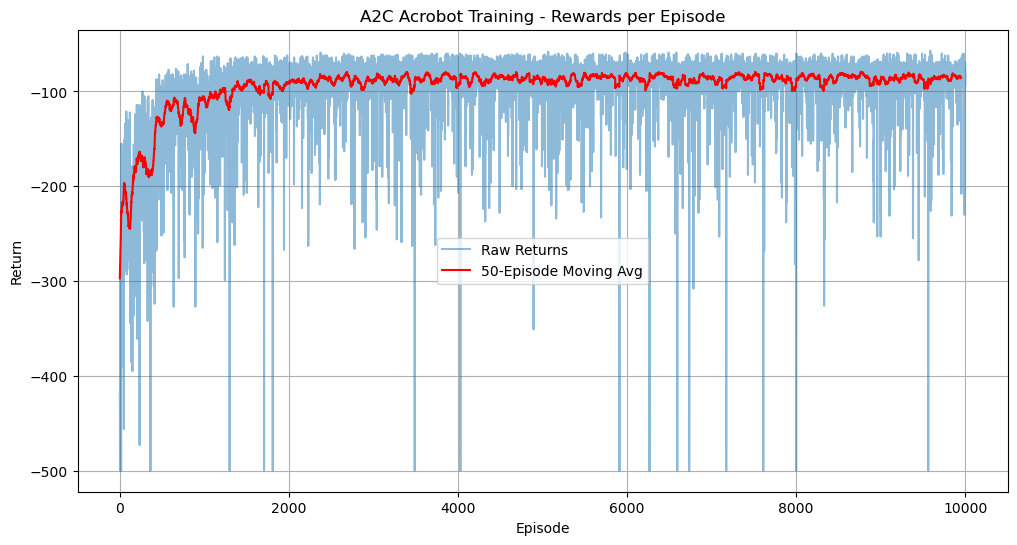

In [15]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C Acrobot Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Testing the trained model for 10 Greedy Episodes

In [57]:
test_env = gym.make('Acrobot-v1')
observation_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n
test_env.close()

# Initializing the network
test_model = Acrobot_A2C_Network(observation_dim, action_dim, hidden_dim)

# Loading the trained model weights
network_weights = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
test_model.load_state_dict(network_weights['state_dict'])
test_model.eval()

greedy_rewards = []

# Testing the trained model for 10 episodes
for ep in range(10):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logit, value = test_model(state_t)
        distributions = torch.distributions.Categorical(logits=logit)
        action_taken = distributions.sample()
        next_state, reward, terminated, truncated, _ = test_env.step(action_taken.item())
        done = truncated or terminated
        total_reward += reward
        state = next_state
        
    print(f"Episode: {ep} Total_reward: {total_reward}")
    greedy_rewards.append(total_reward)
    test_env.close()

Episode: 0 Total_reward: -85.0
Episode: 1 Total_reward: -87.0
Episode: 2 Total_reward: -70.0
Episode: 3 Total_reward: -86.0
Episode: 4 Total_reward: -78.0
Episode: 5 Total_reward: -87.0
Episode: 6 Total_reward: -76.0
Episode: 7 Total_reward: -99.0
Episode: 8 Total_reward: -75.0
Episode: 9 Total_reward: -78.0


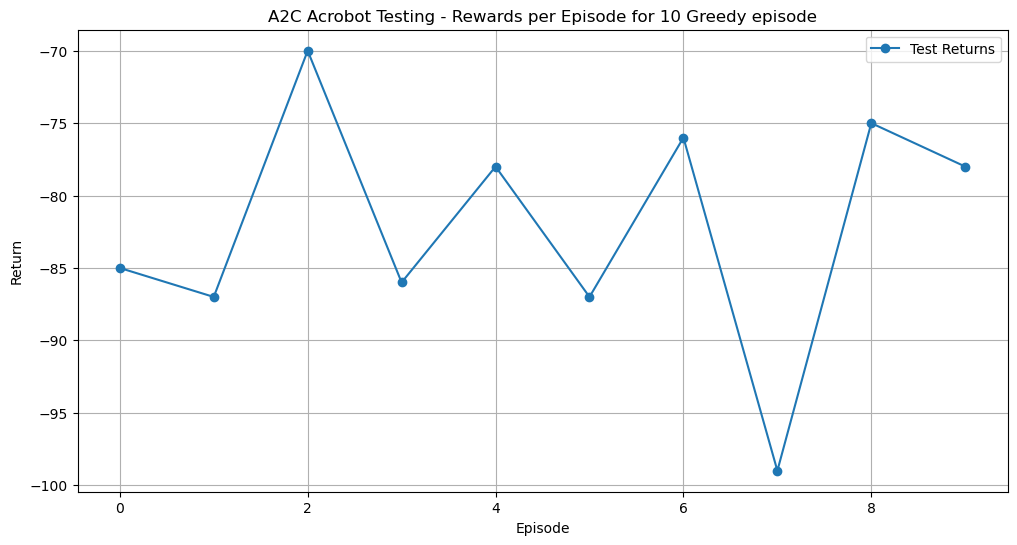

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards, marker='o', label='Test Returns')
plt.title("A2C Acrobot Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

### 2) Gym `BipedalWalker-v3`

#### Creating the required Neural Network for the A2C Model

In [84]:
# Creating an A2C Neural Network with orthogonal initialization for the forward pass
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=512):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden//2)
        self.mean = nn.Linear(hidden//2, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim) - 1.0)
        self.value = nn.Linear(hidden//2, 1)
        
        # Orthogonal initialization for better training stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x  = F.relu(self.fc1(x))
        x  = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.mean(x)
        sd = torch.exp(self.log_std).clamp(min=1e-3)
        v  = self.value(x).squeeze(-1)
        return mu, sd, v

#### Defining the Hyperparameters

In [61]:
env_name = "BipedalWalker-v3"
sync_steps = 16
gamma = 0.99        
entropy_coeff = 0.001
grad_clipped = 0.5     
lr = 5e-5
num_workers = 8
num_episodes = 1000

#### Creating a Worker Function to perform A2C Algorithm

In [ ]:
# Defining the worker function which will be run in parallel using multiprocessing and will interact with the environment and update the global model
def worker(wid, shared_model, optimizer, lock,
           env_name, num_eps, sync_steps, gamma, entropy_coeff, grad_clip, queue):
    
    torch.manual_seed(wid)
    
    # Initiating the environment
    train_env = gym.make(env_name)
    
    # Computing the highest and the lowest action values for the environment
    action_low  = torch.from_numpy(train_env.action_space.low).float()
    action_high = torch.from_numpy(train_env.action_space.high).float()
    
    # Creating the local model for training using the defined neural network
    local_model = ActorCritic(train_env.observation_space.shape[0],
                              train_env.action_space.shape[0])

    # Running for number of episodes assigned to each worker
    for ep in range(1, num_eps+1):
        state, _ = train_env.reset()
        done = False
        episode_reward = 0.0
        steps_in_episode = 0
        
        # Running the episode until it is terminated or truncated
        while not done:
            
             # Creating the variables to store the transitions for each episode
            states, actions, rewards, masks, log_probabilities, values, entropies = [],[],[],[],[],[],[]
            local_model.load_state_dict(shared_model.state_dict())

            # Sync stpes = 16 befor the next update
            for _ in range(sync_steps):
                curr_state = torch.from_numpy(state).float()
                mu, sd, v = local_model(curr_state.unsqueeze(0))
                
                # Sampling action from the policy using the softmax distribution and calculating the entropy
                distribution = torch.distributions.Normal(mu, sd)
                action = distribution.sample().squeeze(0)
                
                # Performing action clipping to take the better action each time and learn efficiently
                action_clipped = torch.max(torch.min(action, action_high), action_low)
                log_probability = distribution.log_prob(action).sum()
                entropy = distribution.entropy().sum()

                # Taking the action in the environment and getting the next state informations
                next_state, reward, terminated, truncated, _ = train_env.step(action_clipped.numpy())
                done = terminated or truncated
                
                if done:
                    mask = 0.0 
                else:
                    mask = 1.0

                # Storing the transitions and other values recieived from the environment
                states.append(curr_state)
                actions.append(action)
                rewards.append(reward)
                masks.append(mask)
                entropies.append(entropy)
                log_probabilities.append(log_probability)
                values.append(v.squeeze(0))

                episode_reward += reward
                state = next_state
                steps_in_episode += 1
                
                if done: 
                    break
                
                if steps_in_episode >= 1000:  # If episode takes too long
                    done = True
                    break

            # Calculating the GT rewards
            if done:
                GT_Reward = 0.0
            else:
                with torch.no_grad():
                    curr_state = torch.from_numpy(state).float()
                    _, _, next_value = local_model(curr_state.unsqueeze(0))
                    GT_Reward = next_value.item()
            
            # Reversing the rewards and calculating the returns
            returns = []
            for r, m in zip(reversed(rewards), reversed(masks)):
                GT_Reward = r + gamma * GT_Reward * m
                returns.insert(0, GT_Reward)
            returns = torch.tensor(returns, dtype=torch.float32)
            value_tensor = torch.stack(values)
            advantage = returns - value_tensor.detach()
            
            # Performing Advantage normalization
            if advantage.numel() > 1 and advantage.std() > 1e-8:
                advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            # Computing the loss for actor and critic using the advantage
            policy_loss = -(torch.stack(log_probabilities) * advantage.detach()).mean()
            value_loss = F.mse_loss(value_tensor, returns)
            entropy = torch.stack(entropies).mean()
            
            # Total loss computation
            tota_loss = policy_loss + 0.5 * value_loss - entropy_coeff * entropy

            # Backpropagate
            optimizer.zero_grad()
            tota_loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), grad_clip)
            
            # Locking the parameter to sync
            with lock:
                for lp, gp in zip(local_model.parameters(),
                                shared_model.parameters()):
                    if gp.grad is None:
                        gp.grad = lp.grad.clone()
                    else:
                        gp.grad += lp.grad
                optimizer.step()
                
        if ep % 50 == 0:
            print(f"[Worker {wid}] Ep {ep:3d} Reward: {episode_reward:7.1f}")
        
        # Adding the episode reward to the queue for plotting
        queue.put(episode_reward)
        state, _ = train_env.reset()

    train_env.close()

#### Creating a Worker Training Function to perform the training using multithreading over multiple workers

In [113]:
# Defining the training function to perform training across multiple workers using python multiple processing
def worker_training():
    
    # Initializing the environment    
    train_env_BW = gym.make(env_name); 
    observation_dimension, action_dimension = train_env_BW.observation_space.shape[0], train_env_BW.action_space.shape[0] 
    train_env_BW.close()
    
    # Creating the global model and sharing it across processes
    shared_model = ActorCritic(observation_dimension, action_dimension)
    shared_model.share_memory()
    optimizer = optim.Adam(shared_model.parameters(), lr=lr)
    
    # Creating a queue to store the rewards for plotting
    queue = mp.Queue()
    lock = mp.Lock()

    # Creating the workers for parallel processing and adding them to train
    processes = []
    print("=== Training started ===")
    for wid in range(num_workers):
        print(f"Starting worker {wid}")
        p = mp.Process(target=worker, args=(
            wid, shared_model, optimizer, lock,
            env_name, num_episodes, sync_steps, gamma,
            entropy_coeff, grad_clipped, queue
        ))
        p.start()
        processes.append(p)

    # Waiting for the workers to finish training and collecting the rewards
    total = num_workers * num_episodes
    returns = [queue.get() for _ in range(total)]
    
    # Joining the workers in the end
    for p in processes:
        p.join()

    mean_R = np.mean(returns)
    print(f"\n=== Training complete ===")
    print(f"Mean return over {total} episodes: {mean_R:.2f}")

    # Saving the trained model and the rewards as pickle files
    checkpoint = {
        'state_dict': shared_model.state_dict(),
        'returns':    returns
    }

    with open('a3_part_2_a2c_bipedalwalker_sgupta67_karamchan.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("Saved the model learning at a3_part_2_a2c_bipedalwalker_sgupta67_karamchan.pkl")

#### Training the agent and storing the Weights in a pickle file

In [ ]:
mp.set_start_method("spawn") 
worker_training()

#### Loading the rewards of the learned model to plot the trend

In [6]:
model_rewards = pickle.load(open('bipedalwalker_a2c_Returns.pkl', 'rb'))

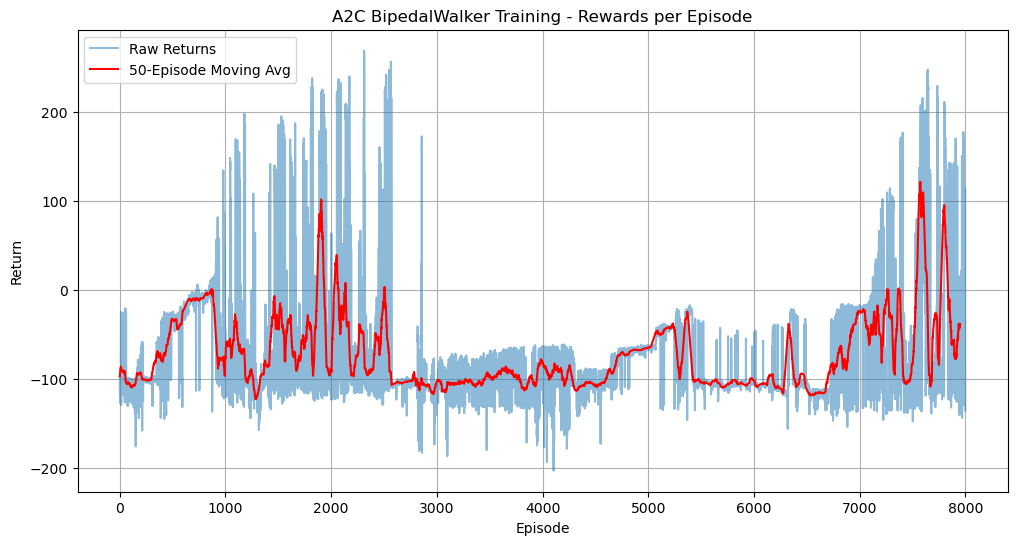

In [64]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(model_rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(model_rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C BipedalWalker Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

#### Testing the trained model for 10 Greedy Episodes

In [ ]:
trained_model_weights = pickle.load(open('a3_part_2_a2c_bipedalwalker_sgupta67_karamchan.pkl','rb'))

env_name = "BipedalWalker-v3"
test_env_bipedal = gym.make(env_name)
obs_dim = test_env_bipedal.observation_space.shape[0]
act_dim = test_env_bipedal.action_space.shape[0]
test_env_bipedal.close()

# Initializing the network
model = ActorCritic(obs_dim, act_dim)

# Loading the trained model weights
model.load_state_dict(trained_model_weights)
model.eval()

greedy_rewards_bipedal = []

# Testing the trained model for 10 episodes
for ep in range(10):
    state, _ = test_env_bipedal.reset()
    done = False
    total_reward = 0.0

    while not done:
        with torch.no_grad():
            mu, sd, _ = model(torch.from_numpy(state).float().unsqueeze(0))
        action = mu.squeeze(0).numpy()
        state, reward, terminated, truncated, _ = test_env_bipedal.step(action)
        total_reward += reward
        done = terminated or truncated
    greedy_rewards_bipedal.append(total_reward)
        
    if total_reward > 0:
        print(f"Episode NO: {ep+1} | Reward: {total_reward:.2f}")
    test_env_bipedal.close()

In [111]:
for ep in range(10):
    print(f"Episode No: {ep+1} | Reward: {greedy_rewards_bipedal[ep]:.2f}")

Episode No: 1 | Reward: -120.84
Episode No: 2 | Reward: -120.38
Episode No: 3 | Reward: 86.27
Episode No: 4 | Reward: -123.35
Episode No: 5 | Reward: 25.54
Episode No: 6 | Reward: 232.76
Episode No: 7 | Reward: -124.87
Episode No: 8 | Reward: -120.89
Episode No: 9 | Reward: -121.39
Episode No: 10 | Reward: -8.10


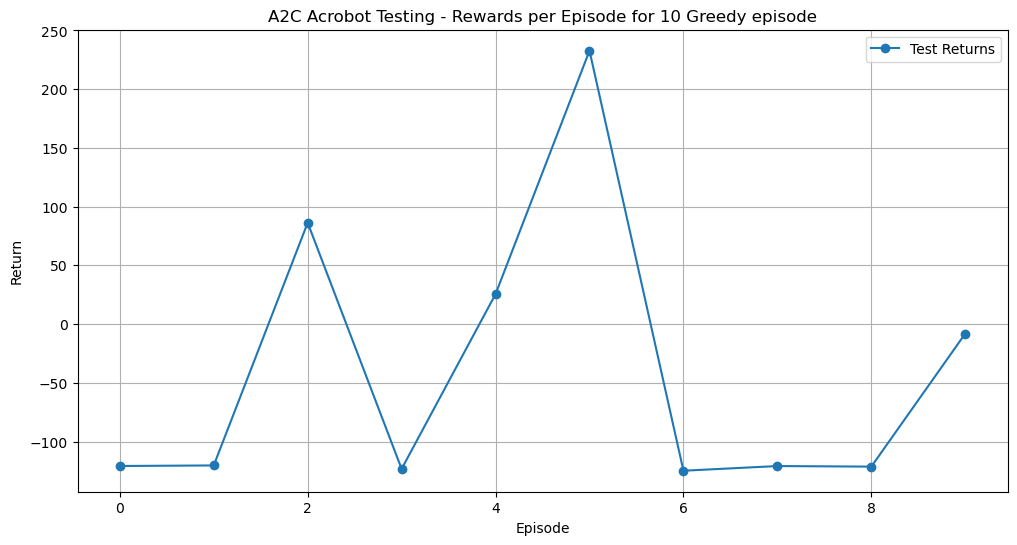

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards_bipedal, marker='o', label='Test Returns')
plt.title("A2C Acrobot Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()